In [1]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 39.4 MB/s eta 0:00:00


H_2

Iteration = 0,  Energy = 0.56743624 Ha,  Convergence parameter = 0.00973536 Ha
Iteration = 20,  Energy = 0.38709233 Ha,  Convergence parameter = 0.00821261 Ha
Iteration = 40,  Energy = 0.24420954 Ha,  Convergence parameter = 0.00616395 Ha
Iteration = 60,  Energy = 0.14079686 Ha,  Convergence parameter = 0.00435028 Ha
Iteration = 80,  Energy = 0.06758408 Ha,  Convergence parameter = 0.00314443 Ha
Iteration = 100,  Energy = 0.01128048 Ha,  Convergence parameter = 0.00262544 Ha
Iteration = 120,  Energy = -0.04175219 Ha,  Convergence parameter = 0.00278160 Ha
Iteration = 140,  Energy = -0.10499504 Ha,  Convergence parameter = 0.00361450 Ha
Iteration = 160,  Energy = -0.19195848 Ha,  Convergence parameter = 0.00511056 Ha
Iteration = 180,  Energy = -0.31444953 Ha,  Convergence parameter = 0.00708743 Ha
Iteration = 200,  Energy = -0.47706980 Ha,  Convergence parameter = 0.00900220 Ha
Iteration = 220,  Energy = -0.66993027 Ha,  Convergence parameter = 0.01001574 Ha
Iteration = 240,  Energy = -

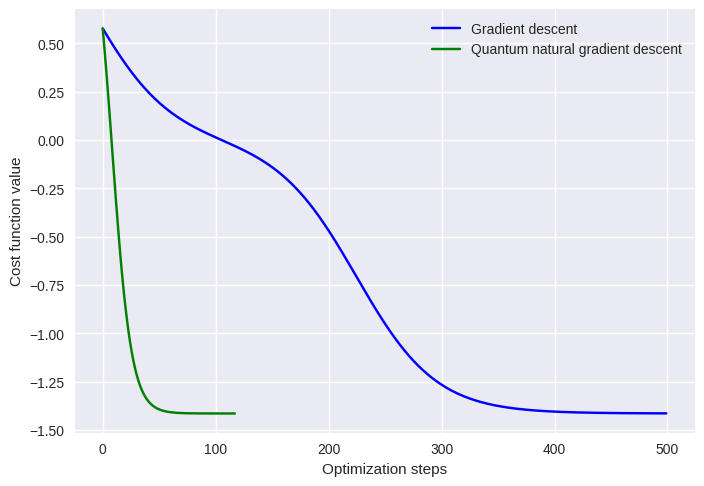

Number of qubits =  4
Iteration = 0,  Energy = -0.09424484 Ha
Iteration = 20,  Energy = -0.55156649 Ha
Iteration = 40,  Energy = -1.12731550 Ha
Iteration = 60,  Energy = -1.13583273 Ha
Iteration = 80,  Energy = -1.13602376 Ha
Iteration = 100,  Energy = -1.13611105 Ha
Iteration = 120,  Energy = -1.13615247 Ha
Final convergence parameter = 0.00000097 Ha
Number of iterations =  130
Final value of the ground-state energy = -1.13616408 Ha
Accuracy with respect to the FCI energy: 0.00002547 Ha (0.01598211 kcal/mol)
Final circuit parameters = 
 [3.44829694e+00 6.28318531e+00 3.78727399e+00 3.42360201e+00
 5.09255717e-08 4.05827240e+00 2.74944154e+00 6.07360246e+00
 6.24620668e+00 2.40923412e+00 6.28318531e+00 3.32314479e+00]
Iteration = 0,  Energy = -0.32164654 Ha
Iteration = 4,  Energy = -0.46875045 Ha
Iteration = 8,  Energy = -0.85090214 Ha
Iteration = 12,  Energy = -1.13575345 Ha
Iteration = 16,  Energy = -1.13618926 Ha

Final convergence parameter = 0.00000022 Ha
Number of iterations =  1

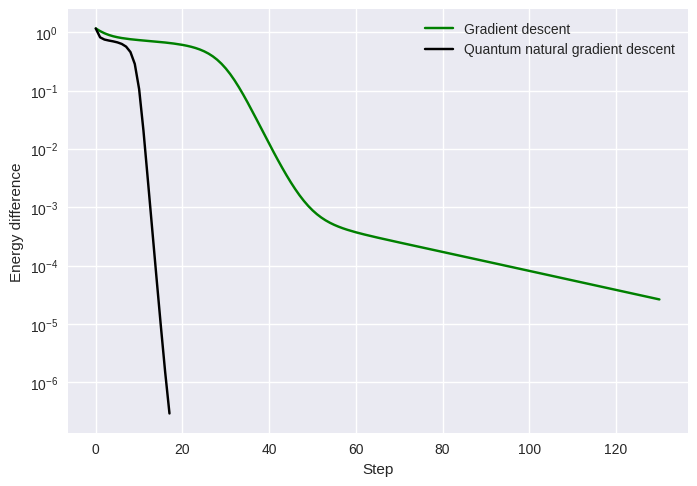

In [2]:
import matplotlib.pyplot as plt
from pennylane import numpy as np
import pennylane as qml

dev = qml.device("default.qubit", wires=1)

def circuit(params, wires=0):
    qml.RX(params[0], wires=wires)
    qml.RY(params[1], wires=wires)

coeffs = [1, 1]
obs = [qml.PauliX(0), qml.PauliZ(0)]

H = qml.Hamiltonian(coeffs, obs)

@qml.qnode(dev, interface="autograd")
def cost_fn(params):
    circuit(params)
    return qml.expval(H)

init_params = np.array([3.97507603, 3.00854038], requires_grad=True)

max_iterations = 500
conv_tol = 1e-06
step_size = 0.01

opt = qml.GradientDescentOptimizer(stepsize=step_size)

params = init_params

gd_param_history = [params]
gd_cost_history = []

for n in range(max_iterations):
    params, prev_energy = opt.step_and_cost(cost_fn, params)
    gd_param_history.append(params)
    gd_cost_history.append(prev_energy)

    energy = cost_fn(params)
    conv = np.abs(energy - prev_energy)

    if n % 20 == 0:
        print("Iteration = {:},  Energy = {:.8f} Ha,  Convergence parameter = {:.8f} Ha".format(n, energy, conv))

    if conv <= conv_tol:
        break

print("Final value of the energy = {:.8f} Ha".format(energy))
print("Number of iterations = ", n)

opt = qml.QNGOptimizer(stepsize=step_size, approx="block-diag")

params = init_params

qngd_param_history = [params]
qngd_cost_history = []

for n in range(max_iterations):
    params, prev_energy = opt.step_and_cost(cost_fn, params)
    qngd_param_history.append(params)
    qngd_cost_history.append(prev_energy)

    energy = cost_fn(params)
    conv = np.abs(energy - prev_energy)

    if n % 20 == 0:
        print("Iteration = {:},  Energy = {:.8f} Ha,  Convergence parameter = {:.8f} Ha".format(n, energy, conv))

    if conv <= conv_tol:
        break

print("Final value of the energy = {:.8f} Ha".format(energy))
print("Number of iterations = ", n)

plt.style.use("seaborn-v0_8")
plt.plot(gd_cost_history, "b", label="Gradient descent")
plt.plot(qngd_cost_history, "g", label="Quantum natural gradient descent")

plt.ylabel("Cost function value")
plt.xlabel("Optimization steps")
plt.legend()
plt.show()

dataset = qml.data.load('qchem',molname="H2", bondlength=0.7)[0]
hamiltonian, qubits = dataset.hamiltonian, len(dataset.hamiltonian.wires)

print("Number of qubits = ", qubits)

dev = qml.device("default.qubit", wires=qubits)
hf_state = np.array([1, 1, 0, 0], requires_grad=False)

def ansatz(params, wires=[0, 1, 2, 3]):
    qml.BasisState(hf_state, wires=wires)
    for i in wires:
        qml.RZ(params[3 * i], wires=i)
        qml.RY(params[3 * i + 1], wires=i)
        qml.RZ(params[3 * i + 2], wires=i)
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[2, 0])
    qml.CNOT(wires=[3, 1])

@qml.qnode(dev, interface="autograd")
def cost(params):
    ansatz(params)
    return qml.expval(hamiltonian)

exact_value = dataset.fci_energy

np.random.seed(0)
init_params = np.random.uniform(low=0, high=2 * np.pi, size=12, requires_grad=True)
max_iterations = 500
step_size = 0.5
conv_tol = 1e-06

opt = qml.GradientDescentOptimizer(step_size)

params = init_params

gd_cost = []

for n in range(max_iterations):
    params, prev_energy = opt.step_and_cost(cost, params)
    gd_cost.append(prev_energy)

    energy = cost(params)
    conv = np.abs(energy - prev_energy)

    if n % 20 == 0:
        print("Iteration = {:},  Energy = {:.8f} Ha".format(n, energy))

    if conv <= conv_tol:
        break

print("Final convergence parameter = {:.8f} Ha".format(conv))
print("Number of iterations = ", n)
print("Final value of the ground-state energy = {:.8f} Ha".format(energy))
print("Accuracy with respect to the FCI energy: {:.8f} Ha ({:.8f} kcal/mol)".format(np.abs(energy - exact_value), np.abs(energy - exact_value) * 627.503))
print("Final circuit parameters = \n", params)

hamiltonian = qml.Hamiltonian(np.array(hamiltonian.coeffs, requires_grad=False), hamiltonian.ops)

opt = qml.QNGOptimizer(step_size, lam=0.001, approx="block-diag")

params = init_params
prev_energy = cost(params)
qngd_cost = []

for n in range(max_iterations):
    params, prev_energy = opt.step_and_cost(cost, params)
    qngd_cost.append(prev_energy)

    energy = cost(params)
    conv = np.abs(energy - prev_energy)

    if n % 4 == 0:
        print("Iteration = {:},  Energy = {:.8f} Ha".format(n, energy))

    if conv <= conv_tol:
        break

print("\nFinal convergence parameter = {:.8f} Ha".format(conv))
print("Number of iterations = ", n)
print("Final value of the ground-state energy = {:.8f} Ha".format(energy))
print("Accuracy with respect to the FCI energy: {:.8f} Ha ({:.8f} kcal/mol)".format(np.abs(energy - exact_value), np.abs(energy - exact_value) * 627.503))
print("Final circuit parameters = \n", params)

plt.style.use("seaborn-v0_8")
plt.plot(np.array(gd_cost) - exact_value, "g", label="Gradient descent")
plt.plot(np.array(qngd_cost) - exact_value, "k", label="Quantum natural gradient descent")
plt.yscale("log")
plt.ylabel("Energy difference")
plt.xlabel("Step")
plt.legend()
plt.show()


In [4]:
import matplotlib.pyplot as plt
from pennylane import numpy as np
import pennylane as qml

# Setup for LiH molecule
symbol = ["Li", "H"]
geometry = np.array([[0.0, 0.0, 0.0], [0.0, 0.0, 1.5474]])  # LiH bond length in Angstroms
charge = 0
multiplicity = 1
basis_set = 'sto-3g'

# Generate the Hamiltonian
hamiltonian, num_qubits = qml.qchem.molecular_hamiltonian(symbol, geometry, charge=charge, mult=multiplicity, basis=basis_set)
dev = qml.device("default.qubit", wires=num_qubits)

def ansatz(params):
    qml.templates.StronglyEntanglingLayers(params, wires=range(num_qubits))

@qml.qnode(dev, interface="autograd")
def cost_fn(params):
    ansatz(params)
    return qml.expval(hamiltonian)

# Initial Parameters
np.random.seed(42)
init_params = np.random.normal(0, np.pi, (4, num_qubits, 3))  # Adjust layers as needed

# Optimization Setup
max_iterations = 200
conv_tol = 1e-06
step_size = 0.4

# Gradient Descent Optimizer
gd_opt = qml.GradientDescentOptimizer(stepsize=step_size)
gd_params = init_params.copy()
gd_cost_history = []

for n in range(max_iterations):
    gd_params, prev_energy = gd_opt.step_and_cost(cost_fn, gd_params)
    gd_cost_history.append(prev_energy)

    energy = cost_fn(gd_params)
    conv = np.abs(energy - prev_energy)

    if n % 10 == 0:
        print(f"Iteration {n}: Energy = {energy:.8f} Ha")

    if conv <= conv_tol:
        print("Convergence reached.")
        break

print(f"Final GD Energy: {energy:.8f} Ha")

# Quantum Natural Gradient Optimizer
qng_opt = qml.QNGOptimizer(stepsize=step_size, approx="block-diag")
qng_params = init_params.copy()
qng_cost_history = []

plt.show()


Iteration 0: Energy = -3.77580989 Ha
Iteration 10: Energy = -3.91352324 Ha
Iteration 20: Energy = -4.08575399 Ha
Iteration 30: Energy = -4.99236289 Ha
Iteration 40: Energy = -5.58819511 Ha
Iteration 50: Energy = -5.67861484 Ha
Iteration 60: Energy = -5.83846968 Ha
Iteration 70: Energy = -6.09361521 Ha
Iteration 80: Energy = -6.31421065 Ha
Iteration 90: Energy = -6.44743802 Ha
Iteration 100: Energy = -6.47161988 Ha
Iteration 110: Energy = -5.17542310 Ha
Iteration 120: Energy = -5.19282584 Ha
Iteration 130: Energy = -5.19656999 Ha
Iteration 140: Energy = -5.20083841 Ha
Iteration 150: Energy = -5.20631613 Ha
Iteration 160: Energy = -5.21331404 Ha
Iteration 170: Energy = -5.22184445 Ha
Iteration 180: Energy = -5.23155786 Ha
Iteration 190: Energy = -5.24179820 Ha
Final GD Energy: -5.25035486 Ha


LinAlgError: Singular matrix

In [6]:
np.random.seed(42)  # Change the seed to get different initial parameters
init_params = np.random.normal(0, np.pi, (4, num_qubits, 3))
qng_opt = qml.QNGOptimizer(stepsize=step_size, lam=0.001)  # Adding regularization to avoid singular matrix

for n in range(max_iterations):
    try:
        qng_params, prev_energy = qng_opt.step_and_cost(cost_fn, qng_params)
        qng_cost_history.append(prev_energy)

        energy = cost_fn(qng_params)
        if n % 10 == 0:
            print(f"Iteration {n}: Energy = {energy:.8f} Ha")
        if conv <= conv_tol:
          break
    except np.linalg.LinAlgError:
        print(f"LinAlgError at iteration {n}: Singular matrix encountered. Adjusting...")
        break

Iteration 0: Energy = -3.82981883 Ha
Iteration 10: Energy = -5.11075167 Ha
Iteration 20: Energy = -4.82411443 Ha
Iteration 30: Energy = -5.38011062 Ha
Iteration 40: Energy = -4.98317994 Ha
Iteration 50: Energy = -5.70860631 Ha
Iteration 60: Energy = -5.43604154 Ha
Iteration 70: Energy = -4.33995053 Ha
Iteration 80: Energy = -5.34374462 Ha
Iteration 90: Energy = -5.07846774 Ha
Iteration 100: Energy = -5.23817561 Ha
Iteration 110: Energy = -4.84465363 Ha
Iteration 120: Energy = -5.33701116 Ha
Iteration 130: Energy = -5.73995272 Ha
Iteration 140: Energy = -5.80889771 Ha
Iteration 150: Energy = -4.55952830 Ha
Iteration 160: Energy = -5.02395632 Ha
Iteration 170: Energy = -4.64622893 Ha
Iteration 180: Energy = -5.01954977 Ha
Iteration 190: Energy = -4.73896733 Ha


Final QNG Energy: -5.18026952 Ha


<ipython-input-7-9700687972e4>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


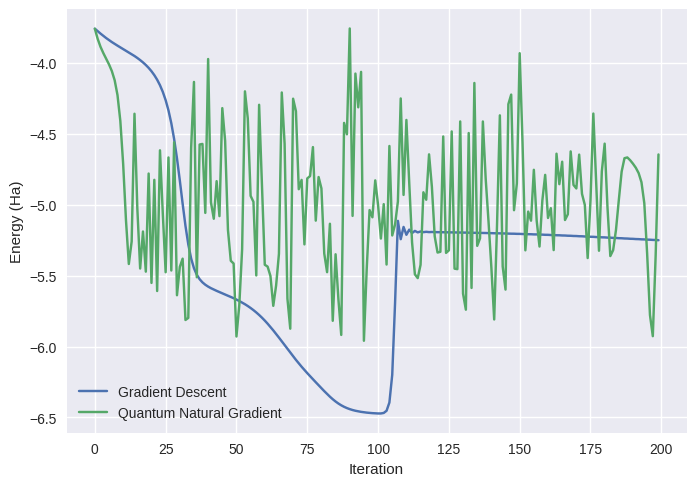

In [7]:
print(f"Final QNG Energy: {energy:.8f} Ha")

# Plotting the results
plt.style.use("seaborn")
plt.plot(gd_cost_history, label="Gradient Descent")
plt.plot(qng_cost_history, label="Quantum Natural Gradient")
plt.ylabel("Energy (Ha)")
plt.xlabel("Iteration")
plt.legend()
plt.show()